Section 7: An example of the EM algorithm
=========================================

I took inspiration from [this Nature paper](http://ai.stanford.edu/~chuongdo/papers/em_tutorial.pdf) and from [this blog post](http://nipunbatra.github.io/2014/04/em/) by Nipun Batra.

In [43]:
%pylab inline

import numpy as np
import scipy.io
from scipy import stats
from astropy.io import ascii
from astropy.table import Table, Column
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import pickle

Populating the interactive namespace from numpy and matplotlib


In [32]:
def neg_loglik(thetas, n, xs, zs):
    return -np.sum([np.log10(np.random.binomial(n[x],thetas[z])) for (x, z) in zip(xs, zs)])

In [108]:
# The outcome of the experiment

observations = np.array([[1,0,0,0,1,1,0,1,0,1],
                         [1,1,1,1,0,1,1,1,1,1],
                         [1,0,1,1,1,1,1,0,1,1],
                         [1,0,1,0,0,0,1,1,0,0],
                         [0,1,1,1,0,1,1,1,0,1]])

In [35]:
# The identity of the coins for each of the 5 trials

coins_id = np.array([False,True,True,False,True])  # When the coin selected was A.

In [36]:
# COMPLETELY OBSERVED CASE

# Set of observations corresponding to coin A

observations[coins_id]

array([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1]])

In [37]:
# Number of heads recorded when A was thrown
 
np.sum(observations[coins_id])

# Probability of head for A given the data would be

1.0*np.sum(observations[coins_id])/observations[coins_id].size

0.8

In [38]:
# Same for B

1.0*np.sum(observations[~coins_id])/observations[~coins_id].size

0.45

In [45]:
# THE EM ALGORITHM (in this case we don't know the identities of the coins)

# We start with an initial guess for the parameters:
# theta_0_A = 0.6
# theta_0_B = 0.5

# The intuitive idea is to guess, assuming those initial thetas, which of the two coins was more likely to
# generate the data for each of the five trials. This is called a completion. We calculate probabilities for each
# possible completion of the missing data and apply a modified version of the likelihood maximization (weighted training)

# First iteration

# We take the first trial and calculate the binomial for each of the two coins

coin_A_pmf_obs_1 = stats.binom.pmf(5,10,0.6)

print coin_A_pmf_obs_1

coin_B_pmf_obs_1 = stats.binom.pmf(5,10,0.5)

print coin_B_pmf_obs_1

0.2006581248
0.24609375


In [49]:
# So coin B is more likely to have generated this first trial. We now normalize to 1 and weight

normalized_coin_A_pmf_obs_1 = coin_A_pmf_obs_1/(coin_A_pmf_obs_1+coin_B_pmf_obs_1)

print normalized_coin_A_pmf_obs_1

normalized_coin_B_pmf_obs_1 = coin_B_pmf_obs_1/(coin_A_pmf_obs_1+coin_B_pmf_obs_1)

print normalized_coin_B_pmf_obs_1


weighted_heads_A_obs_1 = 5*normalized_coin_A_pmf_obs_1
print "Coin A Weighted count for heads in observation 1: %0.2f" %weighted_heads_A_obs_1
weighted_tails_A_obs_1 = 5*normalized_coin_A_pmf_obs_1
print "Coin A Weighted count for tails in observation 1: %0.2f" %weighted_tails_A_obs_1
weighted_heads_B_obs_1 = 5*normalized_coin_B_pmf_obs_1
print "Coin B Weighted count for heads in observation 1: %0.2f" %weighted_heads_B_obs_1
weighted_tails_B_obs_1 = 5*normalized_coin_B_pmf_obs_1
print "Coin B Weighted count for tails in observation 1: %0.2f" %weighted_tails_B_obs_1




0.449148926101
0.550851073899
Coin A Weighted count for heads in observation 1: 2.25
Coin A Weighted count for tails in observation 1: 2.25
Coin B Weighted count for heads in observation 1: 2.75
Coin B Weighted count for tails in observation 1: 2.75


In [80]:
# Lets leave that as the example and now iterate over the five trials

theta_0_A = 0.6
theta_0_B = 0.5

binomial_A = []
binomial_B = []

normal_A = []
normal_B = []

weighted_A_heads = []
weighted_A_tails = []
weighted_B_heads = []
weighted_B_tails = []

for i in arange(shape(observations)[0]):
    
    # Calculate binomials
    bin_A = stats.binom.pmf(sum(observations[i]),shape(observations)[1],theta_0_A)
    bin_B = stats.binom.pmf(shape(observations)[1]-sum(observations[i]),shape(observations)[1],theta_0_B)
    
    #print sum(observations[i]), shape(observations)[1]-sum(observations[i])
    #print bin_A
    binomial_A.append(bin_A)
    #print bin_B
    binomial_B.append(bin_B)
    
    # Normalize
    norm_A = bin_A/(bin_A+bin_B)
    #print norm_A
    normal_A.append(norm_A)
    norm_B = bin_B/(bin_A+bin_B)
    #print norm_B
    normal_B.append(norm_B)
    
    # Weight
    weight_A_heads = sum(observations[i])*norm_A
    #print weight_A_heads
    weighted_A_heads.append(weight_A_heads)
    weight_A_tails = (shape(observations)[1]-sum(observations[i]))*norm_A
    #print weight_A_tails
    weighted_A_tails.append(weight_A_tails)                 
                     
    weight_B_heads = sum(observations[i])*norm_B
    #print weight_B_heads
    weighted_B_heads.append(weight_B_heads)
    weight_B_tails = (shape(observations)[1]-sum(observations[i]))*norm_B
    #print weight_B_tails
    weighted_B_tails.append(weight_B_tails)                      
    
#print sum(weighted_A_heads)
#print sum(weighted_A_tails)
#print sum(weighted_B_heads)
#print sum(weighted_B_tails)

In [82]:
# Now we maximize the weighted likelihood
# We calculate the probability of getting heads for each coin at the end of the iteration from the weighted counts

theta_A_new = sum(weighted_A_heads)/(sum(weighted_A_heads) + sum(weighted_A_tails))
print theta_A_new
theta_B_new = sum(weighted_B_heads)/(sum(weighted_B_heads) + sum(weighted_B_tails))
print theta_B_new


0.713012235401
0.581339308314


In [85]:
# Ok, now let us write a function that does this in an automatic way (a single iteration of the EM algorithm)

def em_single(priors, observations):
    """
    Performs a single EM step
    Arguments
    ---------
    priors : [theta_A, theta_B]
    observations : [m X n matrix]
    
    Returns
    --------
    new_priors: [new_theta_A, new_theta_B]
    """
    counts = {'A':{'H':0, 'T':0}, 'B':{'H':0, 'T':0}}
    theta_A = priors[0]
    theta_B = priors[1]
    
    # E step
    for observation in observations:
        len_observation = len(observation)
        num_heads = observation.sum()
        num_tails = len_observation - num_heads
        contribution_A = stats.binom.pmf(num_heads,len_observation,theta_A)
        contribution_B = stats.binom.pmf(num_heads,len_observation,theta_B)
        weight_A = contribution_A/(contribution_A+contribution_B)
        weight_B = contribution_B/(contribution_A+contribution_B)
        # Incrementing counts
        counts['A']['H']+= weight_A*num_heads
        counts['A']['T']+= weight_A*num_tails
        counts['B']['H']+= weight_B*num_heads
        counts['B']['T']+= weight_B*num_tails
    # M step
    new_theta_A = counts['A']['H']/(counts['A']['H']+counts['A']['T'])
    new_theta_B = counts['B']['H']/(counts['B']['H']+counts['B']['T'])
    return [new_theta_A, new_theta_B]

In [102]:
# Now a procedure to run the algorithm with two convergence criteria: a maximum of 10000 iterations
# or a tolerance of 1E-6:

def em(observations, prior, tol=1e-6, iterations=10000):
    import math
    iteration = 0
    prior_trace = {'trace_A':[prior[0]],'trace_B':[prior[1]]}
    while iteration<iterations:
        new_prior = em_single(prior, observations)
        delta_change = np.abs(prior[0]-new_prior[0])
        if delta_change<tol:
            break
        else:
            prior = new_prior
            prior_trace['trace_A'].append(new_prior[0])
            prior_trace['trace_B'].append(new_prior[1])
            iteration+=1
    plt.plot(prior_trace['trace_A'],'o')
    plt.plot(prior_trace['trace_B'],'o')
    return [new_prior, iteration]

[[0.79678875938310978, 0.51958393567528027], 14]

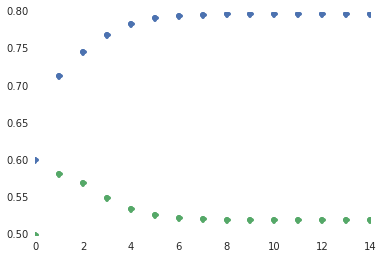

In [109]:
em(observations, [0.6,0.5])